In [1]:
from kevlib import common_import_script
%run $common_import_script
from astropy.coordinates import SkyCoord
from astroscrappy import detect_cosmics
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
import lmfit
from astropy.io import fits
from kevlib.utils.plot import plot_images
from glob import glob
import kevlib.image as kli
from kevlib.utils import fix_byte_order
import urllib.parse
from astropy.io import ascii as astro_ascii
from scipy.ndimage import binary_dilation, binary_erosion


/media/rd1/kwillis/kevlib_dev/src/kevlib/common_imports.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange  # 231010


---------------------------------------------------------------------------------------
|                        Last run date: 2025-07-19 05:44 PM E                         |
---------------------------------------------------------------------------------------
| Python | Jupyterlab | Numpy  | Scipy  | Astropy | Matplotlib | Tensorflow | Pytorch |
---------------------------------------------------------------------------------------
| 3.11.4 |   4.4.3    | 1.24.3 | 1.11.1 |  5.3.1  |   3.8.3    |   2.13.1   |  2.0.1  |
---------------------------------------------------------------------------------------


In [2]:
import numpy as np

def find_patterns(image):
    target_value = 268435456

    height, width = image.shape
    mask_image = np.zeros((height, width), dtype=int)

    for y in range(height - 1):
        for x in range(width - 1):
            if (image[y, x] == target_value and
                image[y, x + 1] == target_value and
                image[y + 1, x] == target_value and
                image[y + 1, x + 1] == target_value):
                
                mask_image[y, x] = 1
                mask_image[y, x + 1] = 1
                mask_image[y + 1, x] = 1
                mask_image[y + 1, x + 1] = 1

            if (image[y, x] == target_value and
                image[y + 1, x + 1] == target_value):
                mask_image[y, x] = 1
                mask_image[y + 1, x + 1] = 1

            if (image[y, x + 1] == target_value and
                image[y + 1, x] == target_value):
                mask_image[y, x + 1] = 1
                mask_image[y + 1, x] = 1

            if image[y, x] == target_value and image[y + 1, x] == target_value:
                mask_image[y, x] = 1
                mask_image[y + 1, x] = 1

            if image[y, x] == target_value and image[y, x + 1] == target_value:
                mask_image[y, x] = 1
                mask_image[y, x + 1] = 1

    for y in range(height - 1):
        if image[y, width - 1] == target_value and image[y + 1, width - 1] == target_value:
            mask_image[y, width - 1] = 1
            mask_image[y + 1, width - 1] = 1

    for x in range(width - 1):
        if image[height - 1, x] == target_value and image[height - 1, x + 1] == target_value:
            mask_image[height - 1, x] = 1
            mask_image[height - 1, x + 1] = 1

    return mask_image


def remove_artifacts(mask, img):
    
    original_img = np.copy(img)
    
    bm = find_patterns(mask)
    c_obj_map = binary_dilation(bm, iterations=4)
    
    img[c_obj_map] = np.nan
    non_nan_pixels = img[~np.isnan(img)]
    background_noise = np.std(non_nan_pixels)
    
    nan_mask = np.isnan(img)
    
    img[nan_mask] = np.random.normal(0, background_noise, size=nan_mask.sum())
    
    # plot_images([mask, original_img, c_obj_map, img], fig_height=2, norm_same=False)
    if (original_img==img).all():
        corrected = False;
    else:
        corrected= True
    return img, corrected

In [3]:
def get_single_file_url(scan_id, scangrp, frame_num):

    irsa_url = "%s/%s/%03d/" % (scangrp, scan_id, frame_num)

    filename = f"{scan_id:s}{frame_num:03d}-w2-int-1b.fits"

    irsa_url = f'https://irsa.ipac.caltech.edu/ibe/data/wise/neowiser/p1bm_frm/{irsa_url}/{filename}'
    
    return irsa_url

#----------------------------------------------------------------------------------------------------------------------------

def URL_list(megalist):
    urllist = []
    for i in megalist:
        url = get_single_file_url(i[1], i[2], int(i[0]))
        urllist.append(url)
    return urllist

def maskImage(path, showImage=False):
    single_path = path
    im_single = fix_byte_order(fits.getdata(single_path))

    s_bkg, s_rms = kli.background.measure_bkg_and_rms(im_single, meas_window_size=[10]*2, outlier_sigma=3, blur_sigma=20, blur_kernel_size=31, device='cuda')
    im_single_br = im_single - s_bkg # Bkg removal
    
    im_single_c = kli.nan_infill(im_single_br, s_rms)

    # im_sg_br / s_rms - > noise normalized
    
    im_coadd = kli.wise.make_wise_coadd(single_path)
    
    c_bkg, c_rms = kli.background.measure_bkg_and_rms(im_coadd, meas_window_size=[10]*2, outlier_sigma=3, blur_sigma=20, blur_kernel_size=31, device='cuda')
    im_coadd_br = im_coadd - c_bkg 
    
    c_obj_map = im_coadd_br > 0.5
    
    c_obj_map = binary_dilation(binary_erosion(c_obj_map, iterations=1), iterations=2)

    
    im_single_masked = im_single_c.copy()
    im_single_masked[c_obj_map] = np.nan
    
    # Measure single bkg and RMS
    
    s_bkg, s_rms = kli.background.measure_bkg_and_rms(
        im_single_masked, meas_window_size=[10]*2, outlier_sigma=3, 
        blur_sigma=20, blur_kernel_size=31, device='cuda',
    )
    # Remove single bkg
    s_b = im_single_masked - s_bkg
    # Infill single NaNs with noise
    s_i = kli.nan_infill(s_b, s_rms)

    #--------------------------------------------------------------------------------------------------------------------------------------------------------
    constant_scaler = 5

    s_norm = s_i.copy()

    low_px_mask = s_norm < -3 * s_rms

    s_norm[low_px_mask] = np.nan
    
    s_norm = kli.nan_infill(s_norm, s_rms)
    
    s_norm /= (s_rms * constant_scaler)


    #--------------------------------------------------------------------------------------------------------------------------------------------------------

    if showImage:
        axs = plot_images(
            ims=[im_single_c, s_i, im_coadd], 
            title=None, norm_same=False, fig_height=4, 
            norm_kwargs=dict(min_cut=-1, max_cut=1000), 
            imshow_kwargs=dict(cmap='viridis')
        )
        [ax.set_title(t) for ax, t in zip(axs, ['Single', 'Masked Single', 'Coadd'])];

    return s_norm, im_coadd, im_single


import numpy as np
from PIL import Image

def grid_image(image_array, square_size):
    corners = []
    image = Image.fromarray(image_array)

    width, height = image.size

    # Calculate the number of squares in both dimensions
    num_squares_x = width // square_size
    num_squares_y = height // square_size

    squares = []
    # Loop through the image and crop it into smaller squares
    for i in range(num_squares_x):
        for j in range(num_squares_y):
            left = i * square_size
            upper = j * square_size
            right = (i + 1) * square_size
            lower = (j + 1) * square_size

            # Crop the square
            square = image.crop((left, upper, right, lower))
            # if left == 0:
            #     print(left, upper, right, lower)
            
            # Convert the square to a NumPy array and append to the list
            square_array = np.array(square)
            squares.append(square_array)

            # midpt = midpoint(left, upper, right, lower)
            corners.append([left,upper])
            # print("corner: ", left, upper)

    return squares, corners


In [4]:
urllist = np.load("./Searches/S1_URLs.npy")
len(urllist)

3389195

In [5]:
urllist = np.unique(urllist)

In [6]:
len(urllist)

755

In [7]:
w1_urls = [url[0:88] + "2" + url[89:] for url in urllist]

In [8]:
len(w1_urls)

755

In [12]:
from kevlib.utils.io import mmcreate, mmload
from tqdm import tqdm
grids = []
topcorners = []
coadds = []
bitmasks = []
singles = []

for i in tqdm(range(len(w1_urls))): 
    for x in range(20):
        try:
            m, coadd, single = maskImage(w1_urls[i])
        except Exception as e:
            print(e)
        else:
            break
    
    squares, corners = grid_image(m, square_size=15)

    bitmask_url = urllist[i][:87] + "w2-msk-1b.fits.gz"
    for x in range(20):
        try:
            bmask = fits.open(bitmask_url)
        except Exception as e:
            print(e)
        else:
            break
    b_mask = bmask[0].data
    b_grid, _ = grid_image(b_mask, 15)
    bmask.close()

   
    grids.append(squares)
    bitmasks.append(b_grid)

print("finished main loop")

deploy_samples = [i for a in grids for i in a]
bitmasks_g = [i for a in bitmasks for i in a]

print("started creating npy files")
# dep = mmcreate("./Searches/2_S1_initial_deploy_grids_W1.npy", dtype=float, shape=(len(deploy_samples), 15, 15), fill_value=0)
# dep.flush()

# bit = mmcreate("./Searches/2_S1_bitmasks_W1.npy", dtype=float, shape=(len(deploy_samples), 15, 15), fill_value=0)
# bit.flush()

finaldep = mmcreate("./Searches/S1_W2_Search_Redo_Masked.npy", dtype=float, shape=(len(deploy_samples), 15, 15), fill_value=0)
finaldep.flush()

print("starting to save data")

for i in range(len(dep)):
    # dep[i, :, :] = deploy_samples[i]
    
    im, c = remove_artifacts(np.array(bitmasks_g[i]), deploy_samples[i])
    finaldep[i, :, :] = im
    
    # dep.flush()
    # bit.flush()
    if i % 20 == 0:
        finaldep.flush()

 28%|██▊       | 213/755 [17:04<45:52,  5.08s/it] 

'NoneType' object has no attribute 'copy'


 65%|██████▍   | 490/755 [38:50<19:16,  4.37s/it]

'NoneType' object has no attribute 'copy'


 72%|███████▏  | 543/755 [43:05<18:16,  5.17s/it]

'NoneType' object has no attribute 'copy'


 97%|█████████▋| 734/755 [58:32<01:32,  4.42s/it]

'NoneType' object has no attribute 'copy'


100%|██████████| 755/755 [1:00:15<00:00,  4.79s/it]


finished main loop
started creating npy files
starting to save data


NameError: name 'dep' is not defined

In [13]:
len(finaldep)

3389195

In [16]:
np.save("w2_s1_initialgrids", deploy_samples)

In [15]:

for i in tqdm(range(len(finaldep))):
    # dep[i, :, :] = deploy_samples[i]
    
    im, c = remove_artifacts(np.array(bitmasks_g[i]), deploy_samples[i])
    finaldep[i, :, :] = im
    
    # dep.flush()
    # bit.flush()
    if i % 20 == 0:
        finaldep.flush()

  0%|          | 5340/3389195 [00:14<2:35:39, 362.30it/s]


KeyboardInterrupt: 

In [17]:
np.save("./Searches/2_S1_initial_deploy_grids_W1.npy", deploy_samples)

In [18]:
len(deploy_samples)
# for i in tqdm(range(len(dep))):
#     dep[i, :, :] = deploy_samples[i]
#     bit[i, :, :] = bitmasks_g[i]
    
#     im, c = remove_artifacts(np.array(bit[i]), dep[i])
#     finaldep[i, :, :] = im
    
#     dep.flush()
#     bit.flush()
#     finaldep.flush()

3389195

In [ ]:
 m, coadd, single = maskImage(w1_urls[i])

In [42]:
m, coadd, single = maskImage(w1_urls[i])

In [33]:
bitmask_url

'https://irsa.ipac.caltech.edu/ibe/data/wise/neowiser/p1bm_frm/0r/42270r/133//42270r133-w1-msk-1b.fits.gz'

In [25]:
len(deploy_samples)

3389195

In [22]:
grids_ex = [f for g in grids for f in g]

In [23]:
np.save("W1_sts_search_grids", grids_ex)

3389195

array([<Axes: >, <Axes: >], dtype=object)

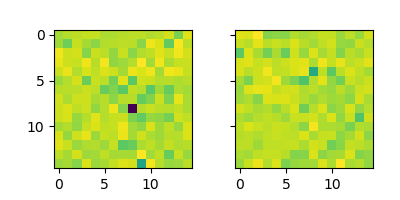

In [36]:
plot_images([grids[-10][-1], deploy_samples[-1]], fig_height=2)

In [ ]:
plot_images(grids[0][0], fig_height=2)

In [38]:
len(w1_urls)

755

In [52]:
raw = fits.getdata(w1_urls[i])
squares, _ = grid_image(raw, square_size=15)
len(squares)

2

In [53]:
w1_ims_raw = []

for i in range(755):
    raw = fits.getdata(w1_urls[i])
    squares, _ = grid_image(raw, square_size=15)
    for square in squares:
        w1_ims_raw.append(square)

In [42]:
len(w1_ims_raw[0][0])

4489

array([<Axes: >], dtype=object)

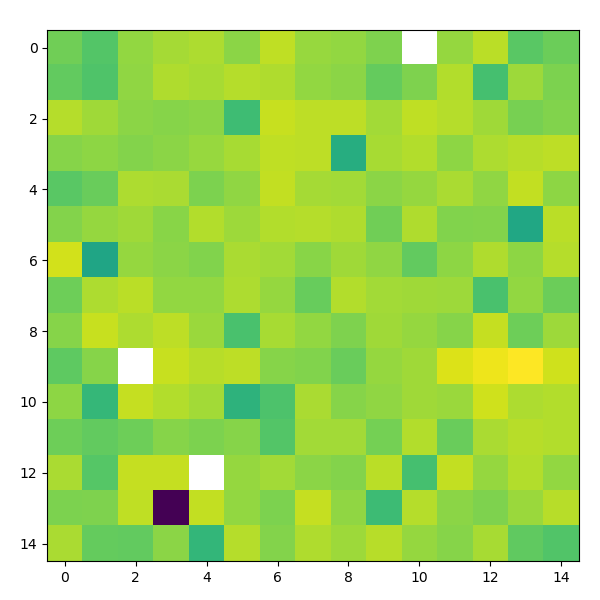

In [45]:
plot_images(w1_ims_raw[0][0][30])

In [1]:
w1_ims_raw = np.array(w1_ims_raw)

In [56]:
len(w1_ims_raw)

3389195

In [57]:
np.save("raw_W1_ims_singles", w1_ims_raw)